<a href="https://colab.research.google.com/github/rounak393/imageprocessing/blob/main/MiDas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Saving 1000096850.jpg to 1000096850 (3).jpg


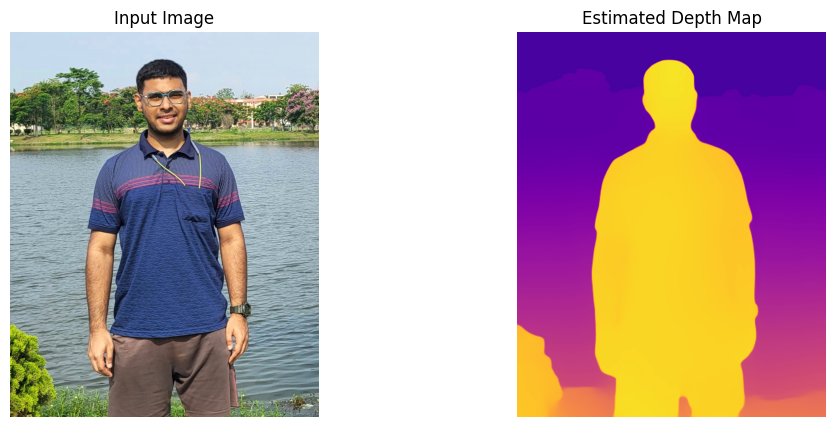

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from google.colab import files
import os

# Load model and transforms
model_type = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDaS", model_type, trust_repo=True)
midas.to("cuda" if torch.cuda.is_available() else "cpu").eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True)
transform = midas_transforms.dpt_transform if "DPT" in model_type else midas_transforms.small_transform

# Upload image
uploaded = files.upload()
input_image_path = list(uploaded.keys())[0]
img = Image.open(input_image_path).convert("RGB")
img_np = np.array(img)

# Apply transform (NOTE: new MiDaS returns tensor directly)
input_tensor = transform(img_np).to("cuda" if torch.cuda.is_available() else "cpu")

# Run inference
with torch.no_grad():
    prediction = midas(input_tensor)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

# Normalize and convert to depth map
depth = prediction.cpu().numpy()
depth_normalized = (depth - depth.min()) / (depth.max() - depth.min())
depth_colored = (plt.cm.plasma(depth_normalized)[:, :, :3] * 255).astype(np.uint8)
depth_image = Image.fromarray(depth_colored)
depth_path = "depth_map.png"
depth_image.save(depth_path)

# Display input and depth map
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(img)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Estimated Depth Map")
plt.imshow(depth_colored)
plt.axis("off")
plt.show()

# Download output
files.download(depth_path)